# 2021-08-27 Finite Difference 2

## Last time
* Evaluating derivatives
* Taylor series and truncation error
* Activity on stability of computing derivatives

## Today

* Stability
* Derivatives as matrices
* Boundary conditions
* Discrete eigenvalues/eigenvectors

In [1]:
using Plots

# Discuss activity on stability and accuracy computing derivatives

# A note on stable computation

In [93]:
x = 1e-15
@show x
@show log(1 + x)

x = 1.0e-15
log(1 + x) = 1.110223024625156e-15


1.110223024625156e-15

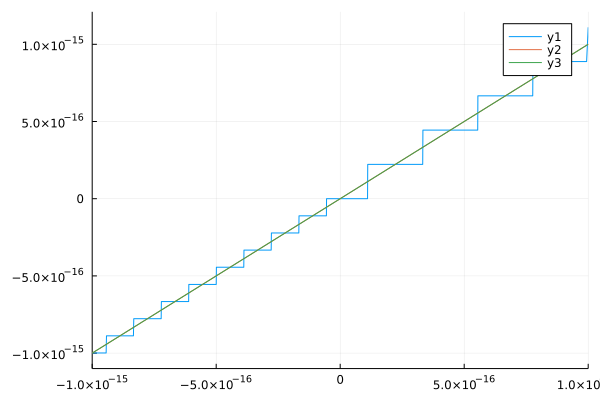

In [95]:
plot([x -> log(1 + x), log1p], xlims=(-1e-15, 1e-15))
plot!(x -> x)

# A few methods on grids

In [99]:
diff1l(x, u) = x[2:end],   (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1r(x, u) = x[1:end-1], (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1c(x, u) = x[2:end-1], (u[3:end] - u[1:end-2]) ./ (x[3:end] - x[1:end-2])
difflist = [diff1l, diff1r, diff1c]

n = 20
h = 2 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)
fig = plot(cos, xlims=(-3, 3))
for d in difflist
    xx, yy = d(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d)
end

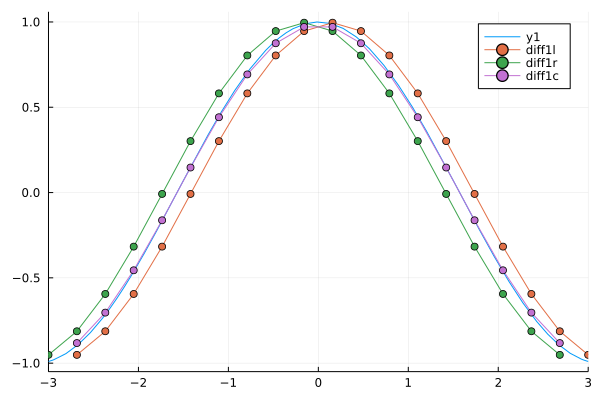

In [100]:
fig

# Measuring error on grids

In [103]:
using LinearAlgebra

grids = 2 .^ (2:10)
hs = 1 ./ grids
function refinement_error(f, fprime, d)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d(x, f.(x))
        push!(error, norm(yy - fprime.(xx), Inf))
    end
    error
end

refinement_error (generic function with 1 method)

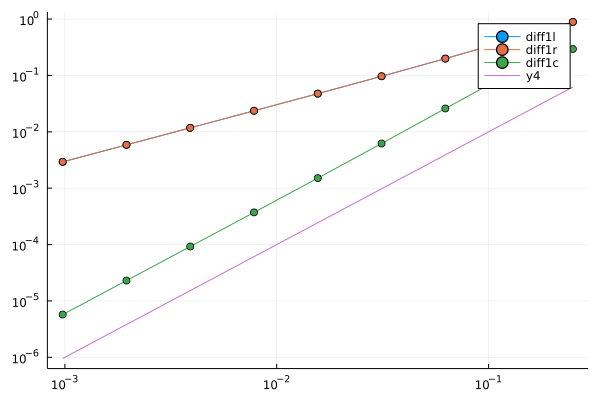

In [105]:
fig = plot(xscale=:log10, yscale=:log10)
for d in difflist
    error = refinement_error(sin, cos, d)
    plot!(fig, hs, error, marker=:circle, label=d)
end
plot!(fig, hs, hs .^ 2)

# Stability

Are there "rough" functions for which these formulas estimate $u'(x_i) = 0$?

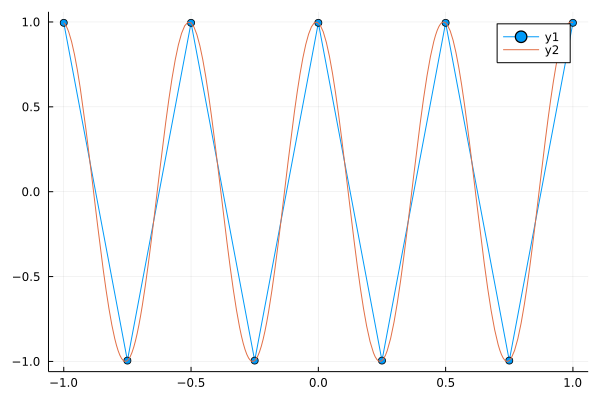

In [107]:
x = LinRange(-1, 1, 9)
f_rough(x) = cos(.1 + 4π*x)
fp_rough(x) = -4π*sin(.1 + 4π*x)

plot(x, f_rough, marker=:circle)
plot!(f_rough)

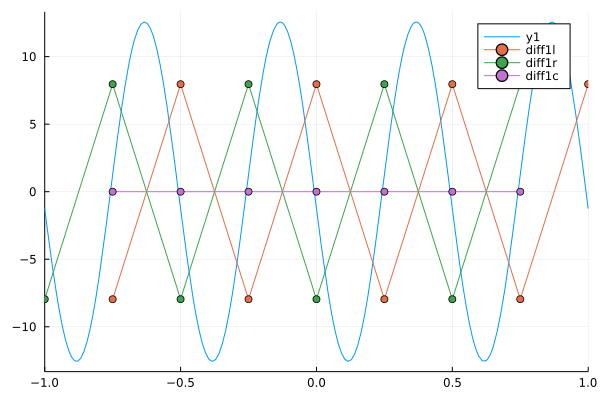

In [108]:
fig = plot(fp_rough, xlims=(-1, 1))
for d in difflist
    xx, yy = d(x, f_rough.(x))
    plot!(fig, xx, yy, label=d, marker=:circle)
end
fig

If we have a solution $u(x)$, then $u(x) + f_{\text{rough}}(x)$ is indistinguishable to our FD method.

# Second derivatives

We can compute a second derivative by applying first derivatives twice.

In [113]:
function diff2a(x, u)
    xx, yy = diff1c(x, u)
    diff1c(xx, yy)
end

function diff2b(x, u)
    xx, yy = diff1l(x, u)
    diff1r(xx, yy)
end

diff2list = [diff2a, diff2b]
n = 10
x = LinRange(-3, 3, n)
u = - cos.(x);

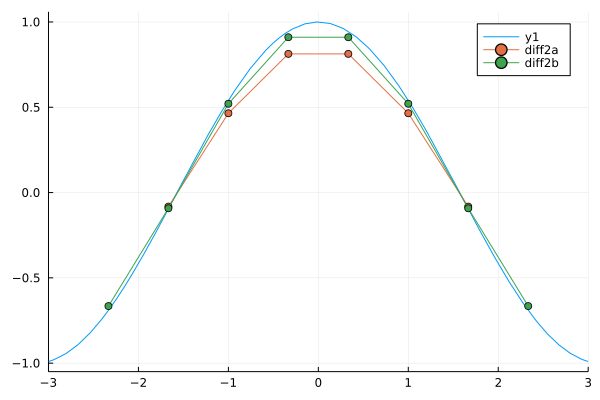

In [114]:
fig = plot(cos, xlims=(-3, 3))
for d2 in diff2list
    xx, yy = d2(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d2)
end
fig

# How fast do these approximations converge?

In [111]:
grids = 2 .^ (3:10)
hs = 1 ./ grids
function refinement_error2(f, f_xx, d2)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d2(x, f.(x))
        push!(error, norm(yy - f_xx.(xx), Inf))
    end
    error
end

refinement_error2 (generic function with 1 method)

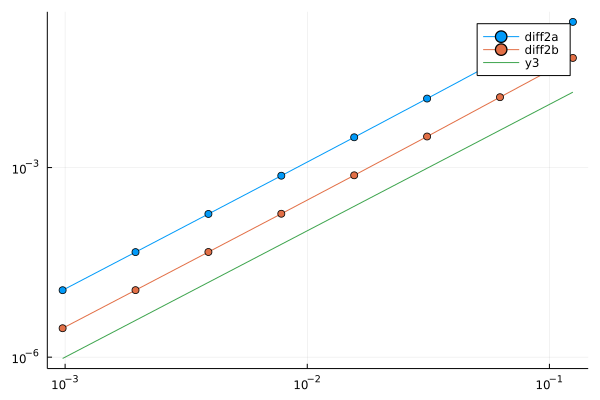

In [112]:
fig = plot(xscale=:log10, yscale=:log10)
for d2 in diff2list
    error = refinement_error2(x -> -cos(x), cos, d2)
    plot!(fig, hs, error, marker=:circle, label=d2)
end
plot!(fig, hs, hs .^ 2) 

* Both methods are second order accurate.
* The `diff2b` method is more accurate than `diff2a` (by a factor of 4)
* The `diff2b` method can't compute derivatives at points adjacent the boundary.
* We don't know yet whether either is stable

# Differentiation matrices

All our `diff*` functions thus far have been linear in `u`, therefore they can be represented as matrices.
$$\frac{u_{i+1} - u_i}{x_{i+1} - x_i} = \begin{bmatrix} -1/h & 1/h \end{bmatrix} \begin{bmatrix} u_i \\ u_{i+1} \end{bmatrix}$$

In [115]:
function diff1_mat(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1:2] = [-1/h  1/h]
    for i in 2:n-1
        D[i, i-1:i+1] = [-1/2h  0  1/2h]
    end
    D[n, n-1:n] = [-1/h  1/h]
    D
end

diff1_mat (generic function with 1 method)

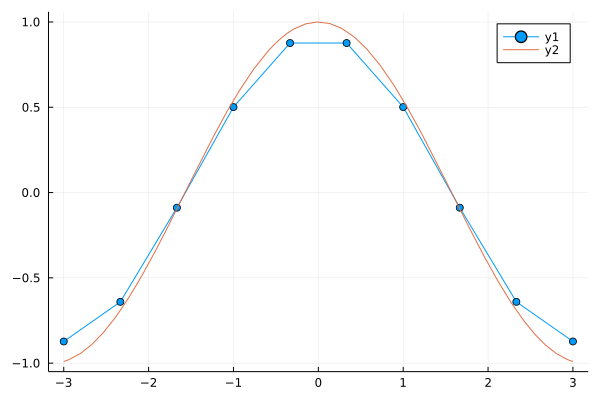

In [119]:
x = LinRange(-3, 3, 10)
plot(x, diff1_mat(x) * sin.(x), marker=:circle)
plot!(cos)

# How accurate is this derivative matrix?

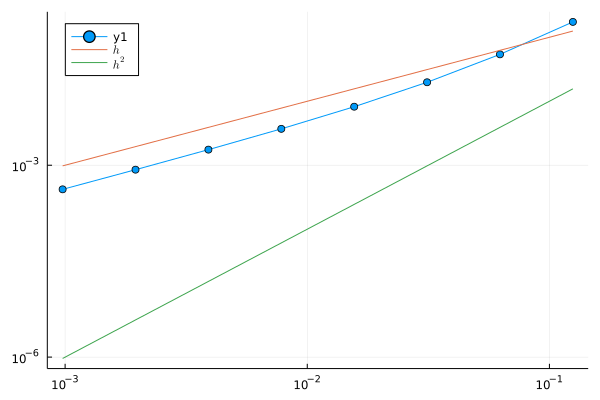

In [120]:
fig = plot(xscale=:log10, yscale=:log10, legend=:topleft)
error = refinement_error(sin, cos, (x, u) -> (x, diff1_mat(x) * u))
plot!(fig, hs, error, marker=:circle)
plot!(fig, hs, hs, label="\$h\$")
plot!(fig, hs, hs .^ 2, label="\$h^2\$")

# Can we study it as a matrix?

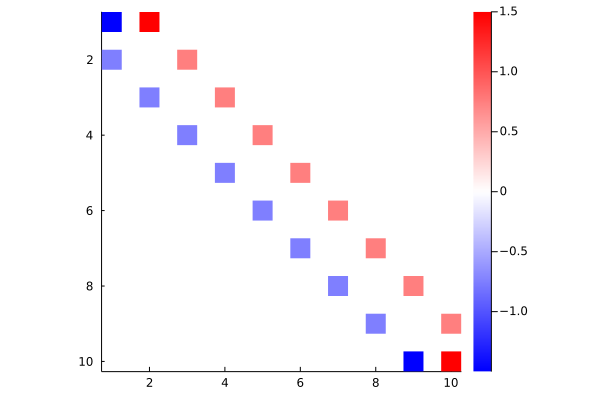

In [121]:
D = diff1_mat(x)
spy(D, marker=(:square, 10), c=:bwr)

In [133]:
svdvals(D)

10-element Vector{Float64}:
 2.268133218393964
 2.2674392839412794
 1.4265847744427302
 1.3683737968309653
 1.2135254915624207
 1.0228485194005281
 0.8816778784387094
 0.5437139466339259
 0.46352549156242107
 3.204643550177702e-17

# Second derivative with Dirichlet boundary conditions

The left endpoint in our example boundary value problem has a Dirichlet boundary condition,
$$u(-1) = a . $$
With finite difference methods, we have an explicit degree of freedom $u_0 = u(x_0 = -1)$ at that endpoint.
When building a matrix system for the BVP, we can implement this boundary condition by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_0 \\ \\ u_{2:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.

In [73]:
function laplacian_dirichlet(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1] = 1
    for i in 2:n-1
        D[i, i-1:i+1] = (1/h^2) * [-1, 2, -1]
    end
    D[n, n] = 1
    D
end

laplacian_dirichlet (generic function with 1 method)

# Laplacian as a matrix

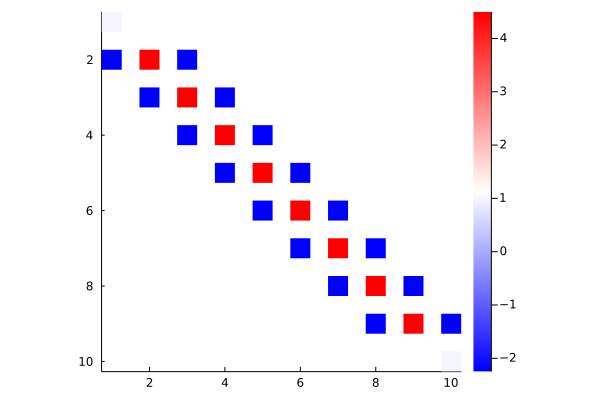

In [123]:
L = laplacian_dirichlet(x)
spy(L, marker=(:square, 10), c=:bwr)

In [124]:
cond(L)

36.554572047954174

# Discrete "Green's functions"

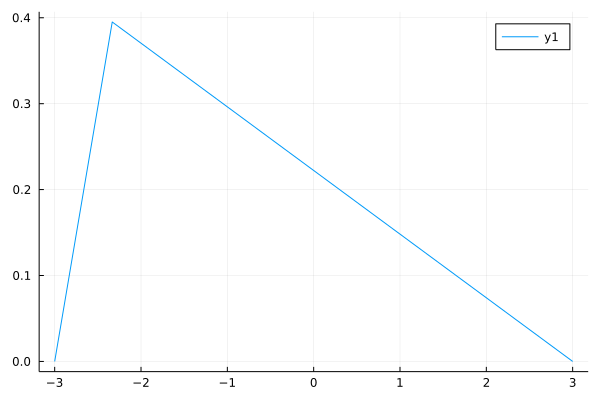

In [81]:
plot(x, inv(L)[:, 2])

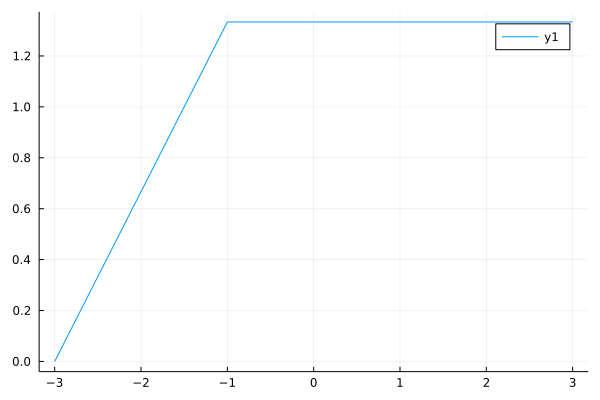

In [82]:
Ln = copy(L)
Ln[n, n-1] = -1
plot(x, inv(Ln)[:, 4])

# Discrete eigenfunctions

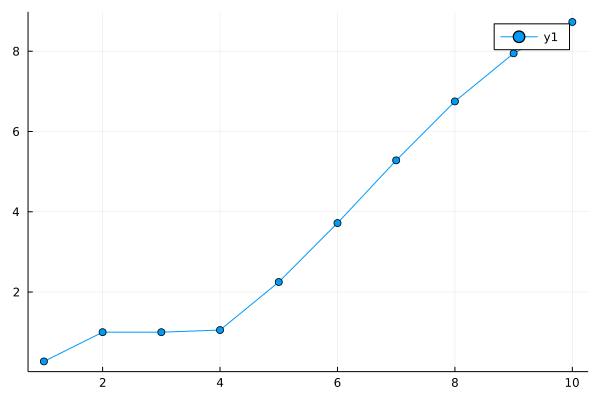

In [125]:
Lambda, V = eigen(L)
plot(Lambda, marker=:circle)

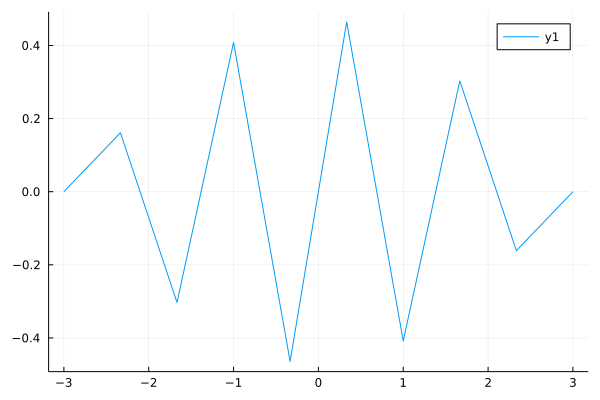

In [131]:
plot(x, V[:, end])